# PyGEM Advanced Test

Brandon Tober, David Rounce<br>
Carnegie Mellon University<br>
20250117<br> <br>
Objective: build on the [*simple_test.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/simple_test.ipynb) demonstration and go over testing PyGEM's more advanced calibration and simulation methods (emulator and Bayesian inference). If you have yet to do so, we suggest going through the simple test notebook in full before proceeding.<br>

>**Note:** in this notebook, any PyGEM Python scripts that are called will be preceeded by ```!```. In Jupyter Notebook, the ```!``` character is used to execute shell commands directly from a notebook cell. When you prefix a command with ```!```, Jupyter sends it to the system's command-line shell for execution, instead of interpreting it as Python code. Command-line arguments are also bracketed (e.g., ```{arg}```), when passing Python variables to a command-line shell from within a Jupyter Notebook. If executing a given PyGEM script directly from one's terminal, remove the ```!``` character and brackets ```{}``` around arguments.
>
>**Also note:** some useful information for any PyGEM script can be displayed by running
```!script -h```

This demonstration follows the *Advanced Test* example in PyGEM's [documentation](https://pygem.readthedocs.io/en/latest/test_pygem_advanced.html) and utilizes PyGEM's *sample_data* for Khumbu Glacier (RGI60-15.03733), which should have been downloaded during model installation and setup (see [here](https://pygem.readthedocs.io/en/latest/install_pygem.html)), but can also be downloaded directly [here](https://drive.google.com/file/d/1Wu4ZqpOKxnc4EYhcRHQbwGq95FoOxMfZ/view?usp=drive_link).<br>

>**Note:** Simply call PyGEM's setup script to download the sample dataset:
```bash 
!setup
```
Ensure that the `root` parameter in PyGEM configuration file points to the correct path for the sample dataset (should end in */sample_data/*, not */sample_data_tw/*):

In [1]:
%%bash
sed -n '16p' ~/PyGEM/config.yaml

root: /Users/btober/PyGEM/sample_data/sample_data/ # note, this parameter must be modfied as to point to the appropriate location. all other paths are assumed relative to this (inputs and outputs).


If the incorrect path is set, you may manually modify with the text editor of your choice so that the `root` parameter is set to point to wherever the appropriate sample dataset is located on your computer.<br>

Proceeding with the simple test, the following steps will be completed:
1. Bayesian inference (MCMC) calibration
2. MCMC future simulation

First, some quick Python imports:

In [2]:
### imports ###
import os, sys, glob, json
from IPython.display import Image, display
# pygem imports
import pygem.setup.config as config
# check for config
config.ensure_config()
# read the config
pygem_prms = config.read_config()   # NOTE: ensure that your root path in ~/PyGEM/config.yaml points to
                                    # the appropriate location. If any errors occur, check this first.
rootpath=pygem_prms['root']

## MCMC calibration

Bayesian inference MCMC calibration should be performed in three steps (further outlined in the [model documentation](https://pygem.readthedocs.io/en/latest/calibration_options.html) and demonstrated in the [*run_calibration.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/run_calibration.ipynb) notebook). In short, we must:

1. Calibrate an enulator for the mass balance model given reference mass balance data. This creates an emulator that helps speed up the simulations within the MCMC methods and helps generate an initial calibration to generate the regional priors.
2. Generate regional priors from all glaciers in a region (not performed in this notebook since we are testing on a single glacier - we'll use regional priors from Rounce et al. ([2023](https://www.science.org/doi/10.1126/science.abo1324))).
3. Perform Bayesian inference calibration using Markov Chain Monte Carlo methods.

### Emulator calibration

Develop an emulator for the glacier mass balance trained upon geodetic observations. The following parameters should either be set within your configuration file, or passed to the *run_calibration* script as command line arguments:
<pre>
glac_no =             15.03733
ref_startyear =       2000
ref_endyear =         2019
option_calibration =  emulator
</pre>

In [3]:
# passing the above parameters as command line arguments:
glac_no = 15.03733
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2019 -option_calibration emulator

Processing: ERA5
1 glaciers in region 15 are included in this model run: ['03733']
This study is focusing on 1 glaciers in region [15]
ERA5 : RGI60-15.03733
Total processing time: 5.476063966751099 s


>**Note:** If running simulations directly from one's terminal, optionall pass the `-v` or `--verbose` command line argument do see plots of the emulator's performance, e.g.:
```bash 
!run_calibration !run_calibration -v
```

If successful, the script will run without errors and the following datasets will be generated:

* *~/sample_data/Output/calibration/15/15.03733-modelprms_dict.json*<br>
* *~/sample_data/emulator/sims/15/15.03733-100_emulator_sims.csv*<br>
* *~/sample_data/emulator/models/15/15.03733-emulator-mb_mwea.pth*<br>
* *~/sample_data/emulator/models/15/15.03733-emulator-mb_mwea_extra.pkl*<br>

These contain the calibration data, simulations used to create the emulator, and information needed to recreate the emulator.

>**Note:** Normally the next step would be to run this for all glaciers in a region and then determine the prior distributions for the MCMC methods; however, given we’re just testing on a single glacier, skip this step and use the default priors from the *~/sample_data/Output/calibration/priors_region.csv*.

If the emulator calibration completed successfully, we can proceed with Bayesian inference model calibration. The following parameters should either be set within your configuration file, or passed to the *run_calibration* script as command line arguments:
<pre>
glac_no =             15.03733
ref_startyear =       2000
ref_endyear =         2019
option_calibration =  MCMC
</pre>

In [4]:
# passing the above parameters as command line arguments:
glac_no = 15.03733
!run_calibration -rgi_glac_number {glac_no} -ref_startyear 2000 -ref_endyear 2019 -option_calibration MCMC -v  -p # `-v` == vervose (will generate some diagnostic plots) and `-p` == progress bar

Processing: ERA5
1 glaciers in region 15 are included in this model run: ['03733']
This study is focusing on 1 glaciers in region [15]
ERA5 : RGI60-15.03733
  mb_data (mwea): -0.45 +/- 0.11
15.03733 chain 0 initials:	tbias: 0.78, kp: 0.91, ddfsnow: 0.0041
20030it [00:17, 1129.69it/s]                                                    
mb_mwea_mean: -0.432 mb_mwea_std: 0.103 
mb_obs_mean: -0.446 mb_obs_std: 0.106
Figure(600x800)
Figure(300x200)
Total processing time: 18.92783498764038 s


Open a couple diagnostic plots. These plots are simply intended to serve as diagnostics of the performance of Bayesian inference calibration.<br><br>

The first plot shows the accepted (orange) and proposed (blue) steps across the MCMC sampling chain for each of PyGEM's three model parameters (temperature bias, precipitation factor, and the degree-day factor of snow, respectively for the top three panels). The fourth panel down shows the modeled mass balance across the chain compared to geodetic observations (with 1- and 2$\sigma$ uncertainty shown by the shaded region). The final panel shows the acceptance rate across the chain (accepted v. proposed samples).<br><br>
For further analysis of MCMC calibration, see the [*analyze_mcmc.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/analyze_mcmc.ipynb) notebook.

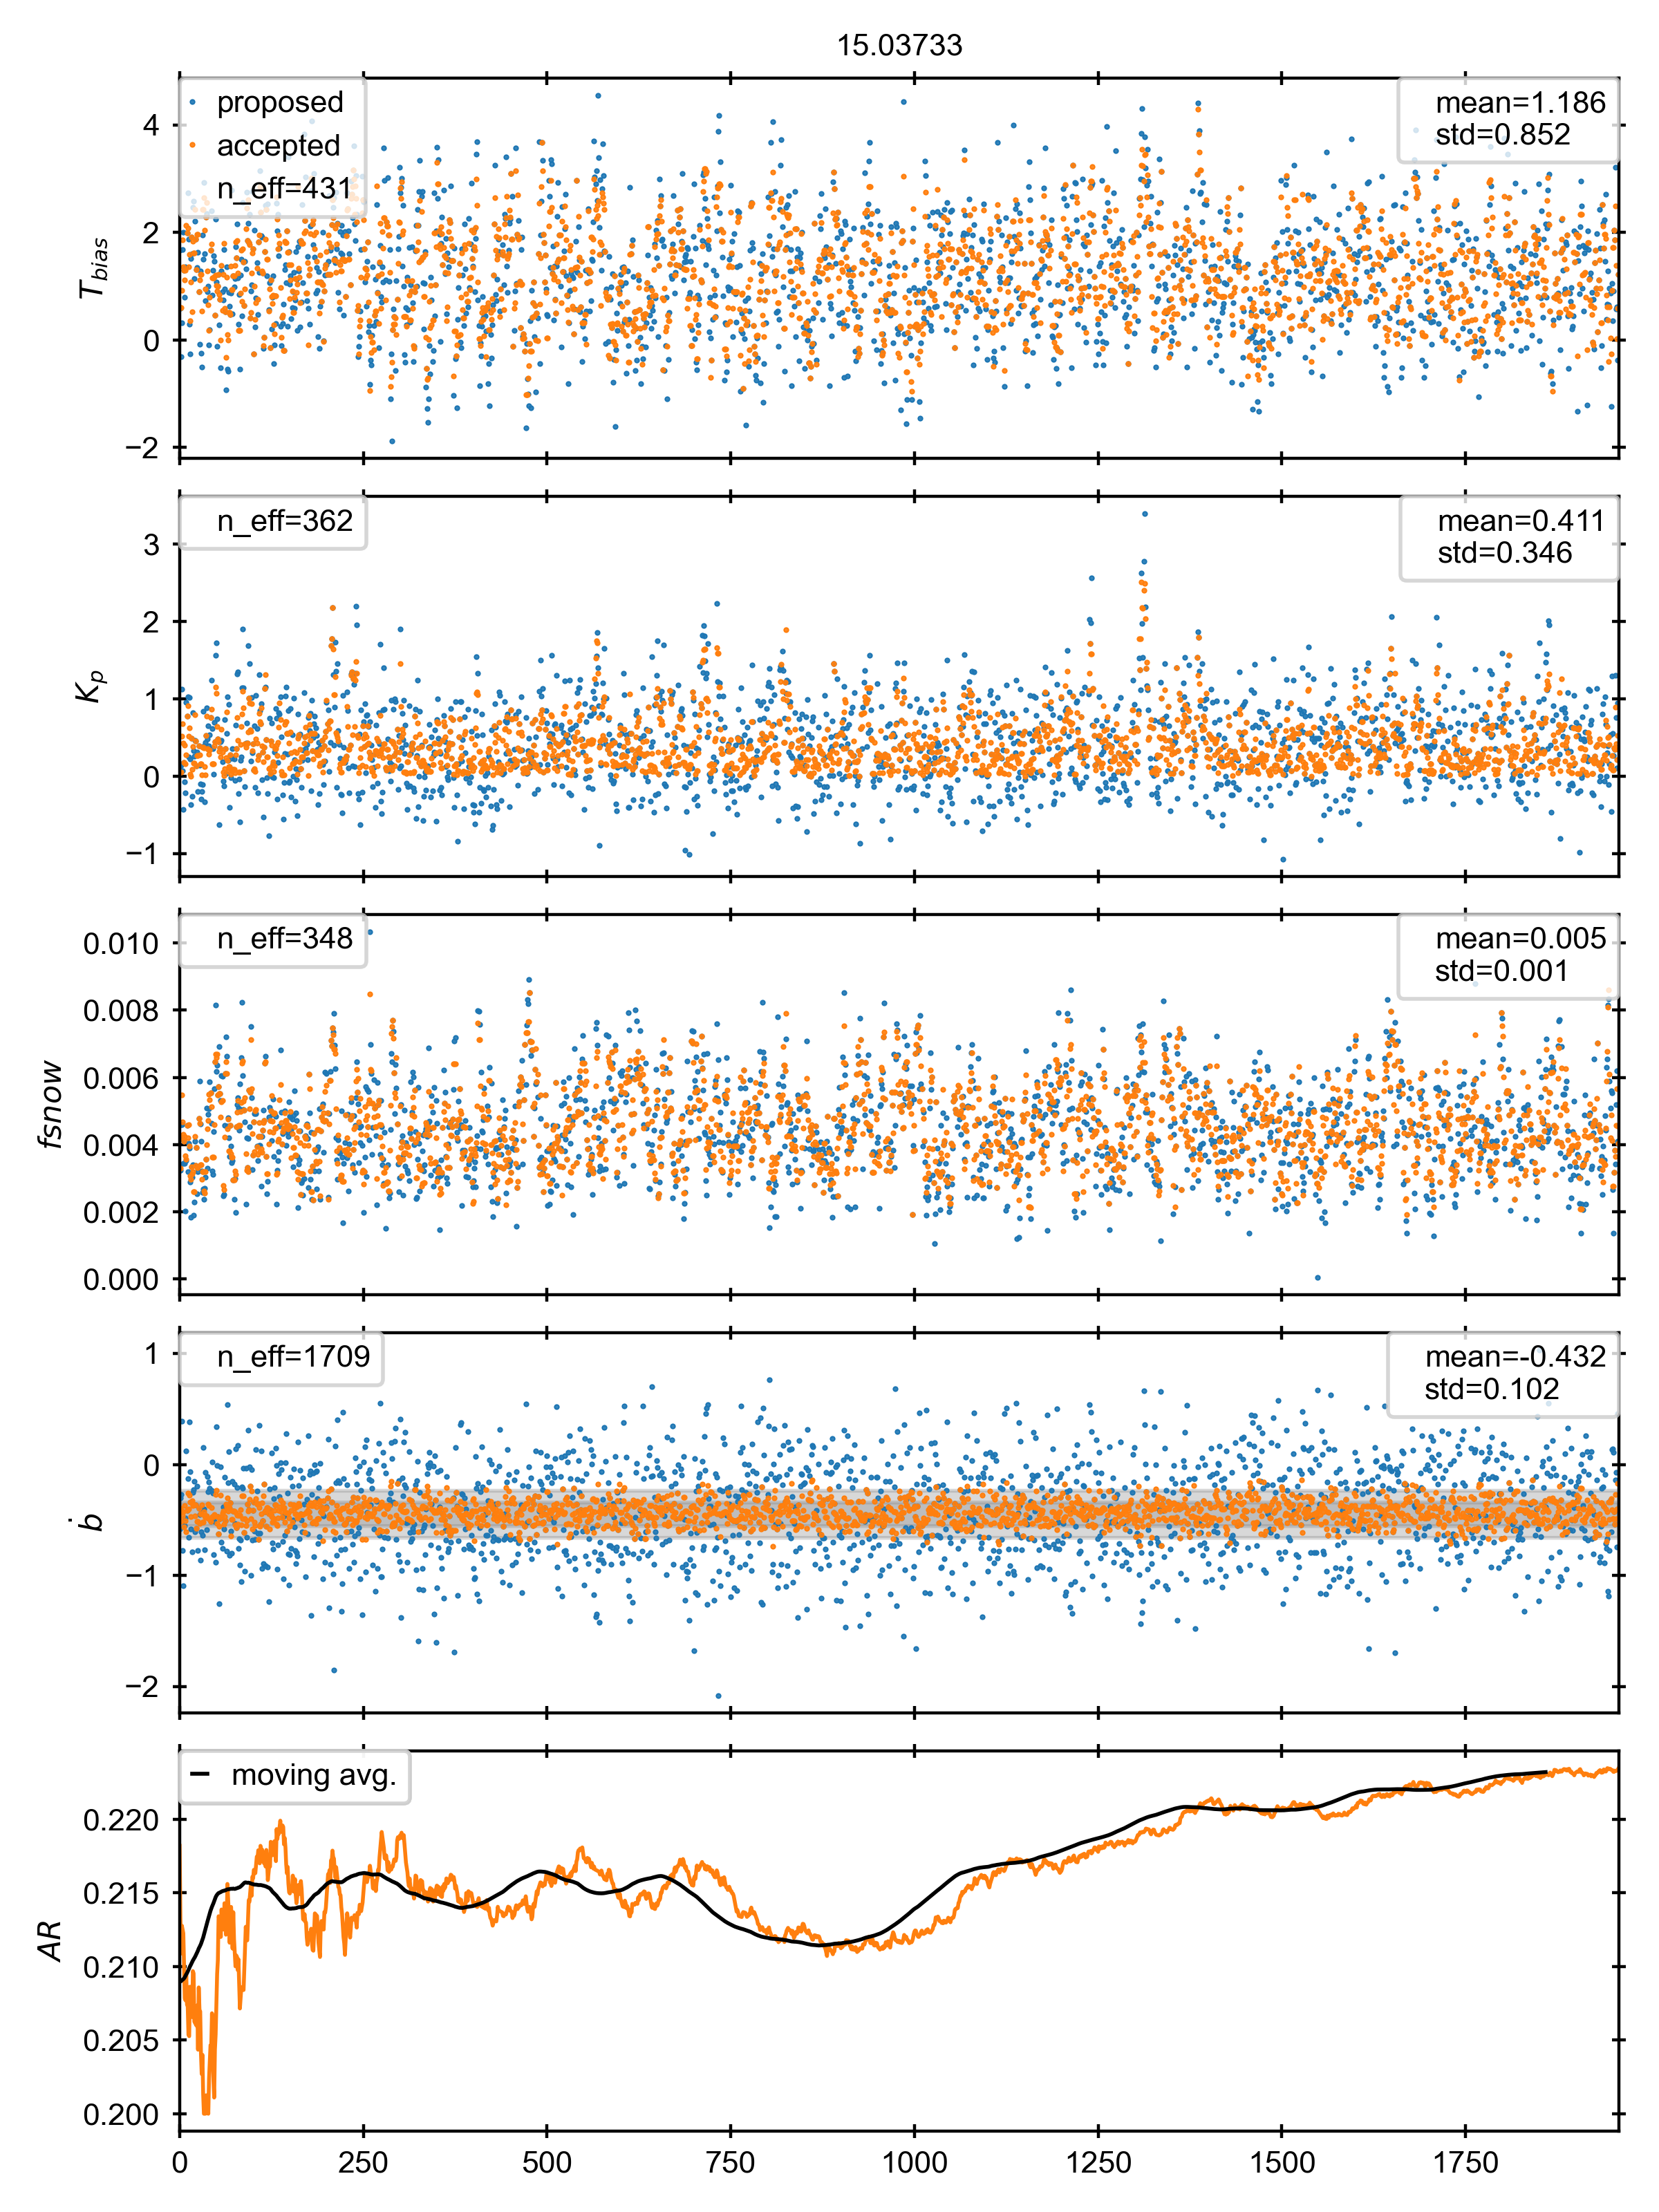

In [5]:
reg = str(glac_no).split('.')[0].zfill(2)
display(Image(filename=f'{rootpath}/Output/calibration/{reg}/fig/{glac_no}-chain0.png', width=500, height=300))

The next plot shows a histogram of the residual mass balance (modeled *minus* observed).

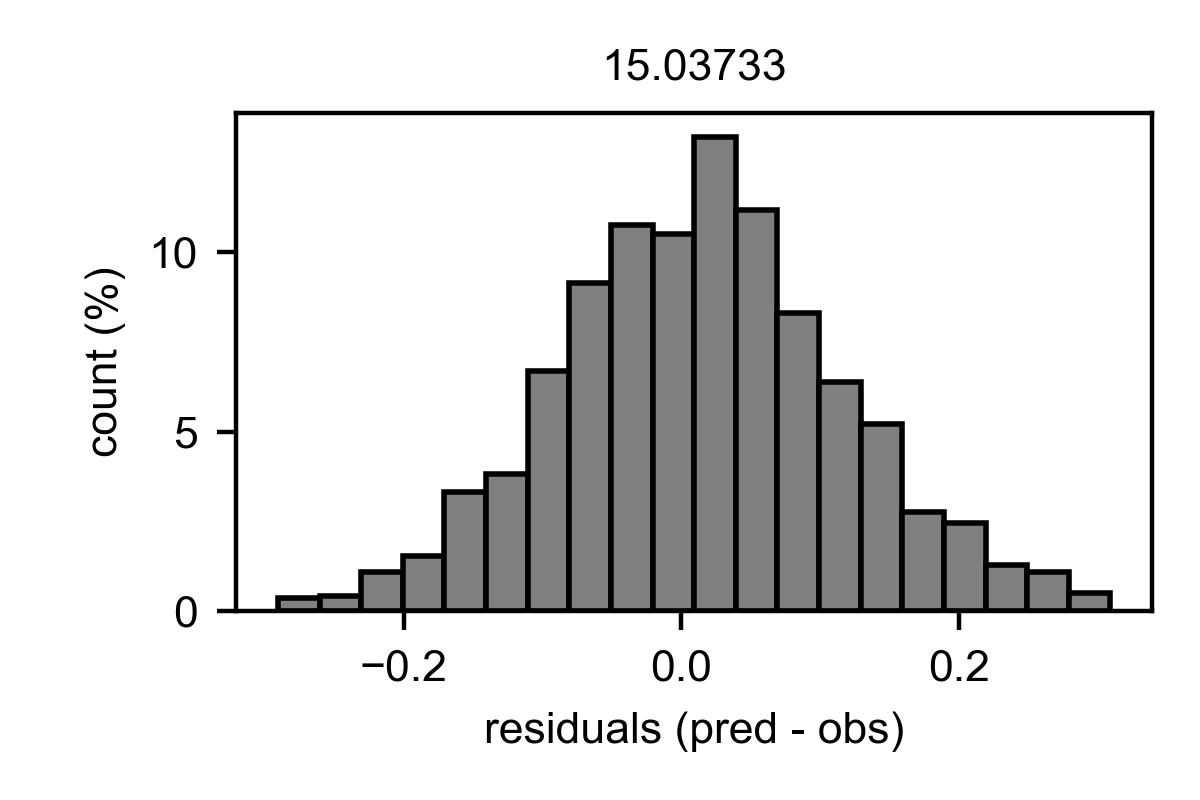

In [6]:
display(Image(filename=f'{rootpath}/Output/calibration/{reg}/fig/{glac_no}-chain0-residuals-0.png', width=300, height=300))

## MCMC simulations

You are now ready to run an MCMC simulation. We’ll skip the simulation for the reference period and go directly to running a future simulation. The following parameters should either be set within your configuration file, or passed to the *run_simulation* script as command line arguments:
<pre>
glac_no =               15.03733
gcm_name =              CESM2
scenario =              ssp245
gcm_startyear =         2000
gcm_endyear =           2100
option_calibration =    MCMC
nsims =                 50
option_dynamics =       OGGM
use_reg_glena =         False         
</pre>


In [7]:
# passing the above parameters as command line arguments:
gcm_name = 'CESM2'
scenario = 'ssp245'
!run_simulation -rgi_glac_number {glac_no} -gcm_name {gcm_name} -scenario {scenario} -gcm_startyear 2000 -gcm_endyear 2100 -option_calibration MCMC -nsims 50 -option_dynamics OGGM -use_reg_glena False

2025-01-18 01:57:15: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2025-01-18 01:57:15: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2025-01-18 01:57:15: oggm.cfg: Multiprocessing: using all available processors (N=10)
2025-01-18 01:57:15: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2025-01-18 01:57:15: oggm.cfg: PARAMS['hydro_month_sh'] changed from `4` to `1`.
2025-01-18 01:57:15: oggm.cfg: PARAMS['trapezoid_lambdas'] changed from `2.0` to `1`.
Processing: CESM2 ssp245
Processing with 1 cores...
1 glaciers in region 15 are included in this model run: ['03733']
This study is focusing on 1 glaciers in region [15]
CESM2 : RGI60-15.03733
Total processing time: 21.71667194366455 s


If successful, we should see the following simulation dataset:

In [8]:
%%bash -s "$rootpath" "$reg" "$gcm_name" "$scenario"
ls -lah $1/Output/simulations/$2/$3/$4/stats/*50sets*.nc

-rw-r--r--@ 1 btober  staff    99K Jan 18 01:57 /Users/btober/PyGEM/sample_data/sample_data//Output/simulations/15/CESM2/ssp245/stats/15.03733_CESM2_ssp245_MCMC_ba1_50sets_2000_2100_all.nc


## Plot

Visualize the model output. First use xarray to load the netcdf file shown above.

In [9]:
import xarray as xr
ds = xr.open_dataset(glob.glob(f'{rootpath}/Output/simulations/{reg}/{gcm_name}/{scenario}/stats/{glac_no}_{gcm_name}_{scenario}_MCMC_*50sets*_2000_2100_all.nc*')[0])
ds

<xarray.Dataset> Size: 56kB
Dimensions:                     (glac: 1, time: 1212, year: 102)
Coordinates:
  * glac                        (glac) int64 8B 0
  * time                        (time) object 10kB 2000-01-01 00:00:00 ... 21...
  * year                        (year) int32 408B 2000 2001 2002 ... 2100 2101
Data variables: (12/18)
    RGIId                       (glac) <U14 56B ...
    CenLon                      (glac) float64 8B ...
    CenLat                      (glac) float64 8B ...
    O1Region                    (glac) int64 8B ...
    O2Region                    (glac) int64 8B ...
    Area                        (glac) float64 8B ...
    ...                          ...
    glac_runoff_monthly_mad     (glac, time) float64 10kB ...
    glac_area_annual_mad        (glac, year) float64 816B ...
    glac_mass_annual_mad        (glac, year) float64 816B ...
    glac_mass_bsl_annual_mad    (glac, year) float64 816B ...
    glac_ELA_annual_mad         (glac, year) float64 816B ...
    offglac_runoff_monthly_mad  (glac, time) float64 10kB ...
Attributes:
    source:            PyGEMv0.3.1
    institution:       Carnegie Mellon University, Pittsburgh PA
    history:           Created by David Rounce (drounce@cmu.edu) on 2025-01-18
    references:        doi:10.1126/science.abo1324
    model_parameters:  {"ref_startyear": 2000, "ref_endyear": 2019, "gcm_star...

We can see the model output dataset above. Note, the default model output for `>1` simulation is to store the median and the median absolute deviation across all simulations (see [here](https://pygem.readthedocs.io/en/latest/model_output.html)). We'll plot the median and median absolute debiation across all 50 simulations for the glacier runorr, mass, and area, but feel free to experiment with other variables and analyses.

In [10]:
# pull monthly runoff and resample to annual values - do this for median and median abs. deviation
ks = ['glac_runoff_monthly', 'glac_runoff_monthly_mad']
runoff = []
for k in ks:
    # runoff is monthly, so sum to yealy vals
    ds_sum = ds[k][0].resample(time='YE').sum('time')
    # append annual runoff to list
    runoff.append(ds_sum.values)

# pull annual area - do this for median and median abs. deviation
ks = ['glac_area_annual', 'glac_area_annual_mad']
area = []
for k in ks:
    # note, PyGEM annual area is the area at the beginning of each model year
    # to align with plotting the total runoff from each year, we'll take index [1:],
    # inidicating we're analyzing values for the end of each model year
    area.append(ds[k][0].values[1:])


# pull annual mass - do this for median and median abs. deviation
ks = ['glac_mass_annual', 'glac_mass_annual_mad']
mass = []
for k in ks:
    # note, PyGEM annual mass is the mass at the beginning of each model year
    # to align with plotting the total runoff from each year, we'll take index [1:],
    # inidicating we're analyzing values for the end of each model year
    mass.append(ds[k][0].values[1:])

# get model years - note indexing [:-1]
# for a simulation that ran from 2000 thru 2100
year = (ds.year.values[:-1:])

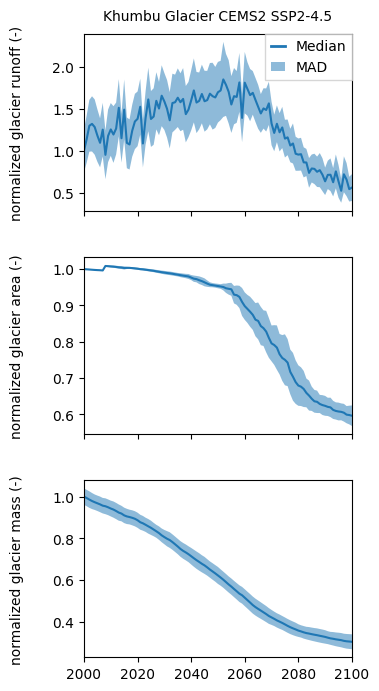

In [11]:
# create 3 x 1 plot with runoff, area, mass
import matplotlib.pyplot as plt
# initialize figure
fig,ax = plt.subplots(3,figsize=(4,7),sharex=True)
ax[0].plot(year,runoff[0]/runoff[0][0], label='Median')
ax[0].fill_between(year,
                    (runoff[0] - runoff[1]) / runoff[0][0],
                    (runoff[0] + runoff[1]) / runoff[0][0],
                    alpha=.5,
                    label='MAD')

ax[1].plot(year,area[0]/area[0][0])
ax[1].fill_between(year,
                    (area[0] - area[1]) / area[0][0],
                    (area[0] + area[1]) / area[0][0],
                    alpha=.5)

ax[2].plot(year,mass[0]/mass[0][0])
ax[2].fill_between(year,
                    (mass[0] - mass[1]) / mass[0][0],
                    (mass[0] + mass[1]) / mass[0][0],
                    alpha=.5)

# create legend
leg = ax[0].legend(fancybox=False,borderaxespad=0,handlelength=1,loc='upper right')
# increase linewidths in legend

for line in leg.get_lines():
    line.set_linewidth(2)
    
# set x axis limits to temporal extent of our data
ax[0].set_xlim([2000,2100])
# create x and y axis labels
ax[0].text(-0.25, 0.5, 'normalized glacier runoff (-)', va='center', ha='center', rotation=90, transform=ax[0].transAxes)
ax[1].text(-0.25, 0.5, 'normalized glacier area (-)', va='center', ha='center', rotation=90, transform=ax[1].transAxes)
ax[2].text(-0.25, 0.5, 'normalized glacier mass (-)', va='center', ha='center', rotation=90, transform=ax[2].transAxes)
# title
ax[0].text(.5, 1.1, 'Khumbu Glacier CEMS2 SSP2-4.5', va='center', ha='center', rotation=0, transform=ax[0].transAxes)
fig.tight_layout()

## Next: try an even more advanced test (for a tide-water glacier)
See, the [*advanced_test_tw.ipynb*](https://github.com/PyGEM-Community/PyGEM-notebooks/blob/main/advanced_test_tw.ipynb) Jupyter Notebook.